# Analysis of lines spoken by main characters by season

We'll parse the Simpsons database of episodes and scripts to look at how the dialogue varies for the main characters by episode and season.

In [40]:
# imports
import bs4
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib
import time
%matplotlib inline
import psycopg2
from sqlalchemy import create_engine

## Connect to PostgreSQL database of Simpsons scripts

In [3]:
# connect to postgresl
dbname = 'simpsonsscripts'
username = 'hsf001'

con = None
con = psycopg2.connect(database = dbname, user = username)

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://hsf001@localhost/simpsonsscripts


## Pull scripts from one season and sort by character

We'll focus on one season and count how many lines are attributed to each of the main characters (Homer Simpson, Marge Simpson, Bart Simpson, and Lisa Simpson) in each episode.

In [4]:
# SQL query for script from one episode: Season 5, Episode 5

sql_query = """
SELECT ep.season, ep.number, ep.name, scripts.text FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5' AND ep.number='5'
"""
output_from_sql = pd.read_sql_query(sql_query,con)
output_from_sql.head()

,season,number,name,text
0,5,5,Treehouse of Horror IV,"Richard Nixon: Yes, Master."
1,5,5,Treehouse of Horror IV,(NIGHT GALLERY-TYPE SET: int. night gallery-ty...
2,5,5,Treehouse of Horror IV,Bart Simpson: Paintings. Lifeless images rend...
3,5,5,Treehouse of Horror IV,Bart Simpson: They become portals to hell so ...
4,5,5,Treehouse of Horror IV,Marge Simpson: Bart! You should warn people t...


In [5]:
# SQL query for number of lines for a character for each episode in a season

sql_query = """
SELECT ep.number, COUNT(*) FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Homer Simpson: %'
  GROUP BY ep.number
  ORDER BY ep.number
"""

home_sea05 = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT ep.number, COUNT(*) FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Marge Simpson: %'
  GROUP BY ep.number
  ORDER BY ep.number
"""

marg_sea05 = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT ep.number, COUNT(*) FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Bart Simpson: %'
  GROUP BY ep.number
  ORDER BY ep.number
"""

bart_sea05 = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT ep.number, COUNT(*) FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Lisa Simpson: %'
  GROUP BY ep.number
  ORDER BY ep.number
"""

lisa_sea05 = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT ep.number, COUNT(*) FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Maggie Simpson: %'
  GROUP BY ep.number
  ORDER BY ep.number
"""

magg_sea05 = pd.read_sql_query(sql_query,con)

# SQL query to get episode names

sql_query = """
SELECT number, name FROM episodes WHERE season='5'
"""

name_sea05 = pd.read_sql_query(sql_query,con)
name_sea05.head()

,number,name
0,1,Homer's Barbershop Quartet
1,2,Cape Feare
2,3,Homer Goes to College
3,4,Rosebud
4,5,Treehouse of Horror IV


In [ ]:
# example for data format and stacked bar plot
#df = pd.DataFrame(columns=["Character","One","Two","Three"],
#                  data=[["Homer",1,2,3],
#                        ["Marge",1,3,5]])
#sns.set()
#df.set_index('Character').T.plot(kind='bar', stacked=True)

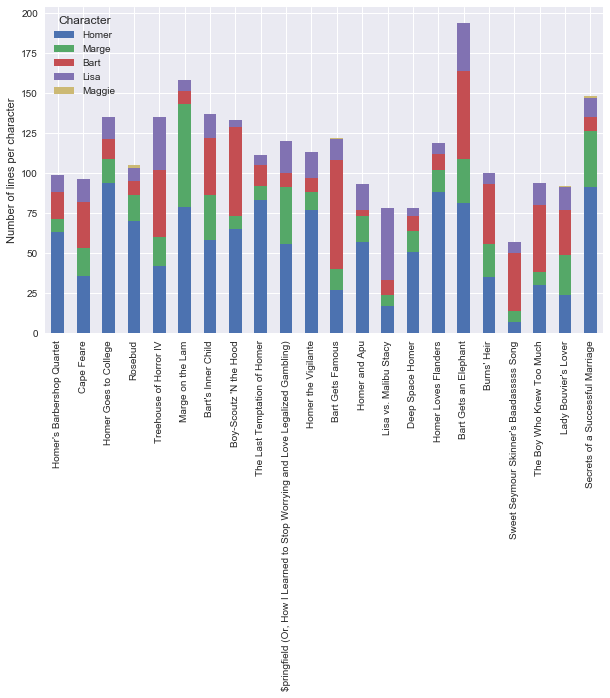

In [6]:
# make episode number integer
home_sea05['number']=home_sea05['number'].astype(int)
marg_sea05['number']=marg_sea05['number'].astype(int)
bart_sea05['number']=bart_sea05['number'].astype(int)
lisa_sea05['number']=lisa_sea05['number'].astype(int)
magg_sea05['number']=magg_sea05['number'].astype(int)

# sort lines per character by episode number
home_sea05.sort_values(by='number', inplace=True)
marg_sea05.sort_values(by='number', inplace=True)
bart_sea05.sort_values(by='number', inplace=True)
lisa_sea05.sort_values(by='number', inplace=True)
magg_sea05.sort_values(by='number', inplace=True)

# create dataframe from data
columns=["Character"]
columns.extend(name_sea05['name'].tolist())
homer=["Homer"]
homer.extend(home_sea05['count'].tolist())
marge=["Marge"]
marge.extend(marg_sea05['count'].tolist())
bart=["Bart"]
bart.extend(bart_sea05['count'].tolist())
lisa=["Lisa"]
lisa.extend(lisa_sea05['count'].tolist())

# fix maggie's lines since she doesn't have lines in all episodes

n_ep = max(home_sea05['number'])

magg_sea05_lines = []

for ii in range(n_ep):
    if (ii+1) in magg_sea05['number'].tolist():
        #magg_sea05_lines.append(magg_sea05[ii+1]['count'])
        magg_sea05_lines.append(magg_sea05[magg_sea05['number']==(ii+1)]['count'].values[0])
    else:
        magg_sea05_lines.append(0)

maggie=["Maggie"]
maggie.extend(magg_sea05_lines)

df = pd.DataFrame(columns=columns,
                  data=[homer,
                        marge,
                        bart,
                        lisa,
                        maggie])

# plot stacked bar chart of character lines by episode name
sns.set()
fig,ax=plt.subplots(figsize=(10,6))
df.set_index('Character').T.plot(kind='bar', stacked=True, ax=ax)
#plt.xlabel('Episode')
plt.ylabel('Number of lines per character')

The above plot for character lines by episode for season 5 looks reasonable. Homer generally has the most lines in every episode, but for episodes centered on other characters (e.g., Marge on the Lam, Bart Gets Famous, Lisa vs. Malibu Stacy), we see the ratios shift accordingly.

In [7]:
# Out of curiosity, what were Maggie's lines in season 5?

sql_query = """
SELECT ep.number, ep.name, scripts.text FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Maggie Simpson: %'
"""

sql_out = pd.read_sql_query(sql_query,con)
sql_out['number']=sql_out['number'].astype(int)
sql_out.sort_values(by='number', inplace=True)
sql_out

,number,name,text
0,4,Rosebud,Maggie Simpson: (WHIMPERS)
1,4,Rosebud,Maggie Simpson: (SOBS)
2,12,Bart Gets Famous,Maggie Simpson: (SUCK)
4,21,Lady Bouvier's Lover,Maggie Simpson: (SCARED SOUNDS)
3,22,Secrets of a Successful Marriage,"Maggie Simpson: (TWO SLOW, NON COMMITTAL SUCKS)"


In [8]:
# When does Lisa have more lines than Bart?

sql_query = """
SELECT sub1.epname, sub1.epnumber
FROM (
  SELECT ep.number AS epnumber, ep.name AS epname, count(*) AS lcount
  FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE ep.season='5'
    AND scripts.text LIKE 'Lisa Simpson: %'
  GROUP BY ep.name, ep.number ) sub1
JOIN (
  SELECT ep.number AS epnumber, ep.name AS epname, count(*) AS bcount
  FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE ep.season='5'
    AND scripts.text LIKE 'Bart Simpson: %'
  GROUP BY ep.name, ep.number ) sub2
ON sub1.epname = sub2.epname
WHERE lcount > bcount
"""

sql_out = pd.read_sql_query(sql_query,con)
sql_out

,epname,epnumber
0,"$pringfield (Or, How I Learned to Stop Worryin...",10
1,Homer Goes to College,3
2,Homer and Apu,13
3,Homer the Vigilante,11
4,Lisa vs. Malibu Stacy,14
5,Secrets of a Successful Marriage,22


In [9]:
# When does Lisa have more lines than Bart?

#output = bart_sea05.merge(lisa_sea05, on='number')
output = bart_sea05['count'] - lisa_sea05['count'] > 0
#output

In [10]:
# average number of lines for a character in a season

sql_query = """
SELECT CAST(homelines AS float)/CAST(numeps AS float) AS homers_avg_lines_per_episode
FROM (
  SELECT COUNT(*) AS homelines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Homer Simpson: %' ) sub1
, (
  SELECT COUNT(*) AS numeps FROM episodes
  WHERE season='5') sub2
"""

sql_out = pd.read_sql_query(sql_query,con)
sql_out

,homers_avg_lines_per_episode
0,55.954545


In [11]:
# average number of lines per episode for a character in first 15 seasons

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(numeps AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  AND scripts.text LIKE 'Homer Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS numeps FROM episodes
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

#sql_query = """
#  SELECT season, COUNT(*) AS homelines FROM episodes ep  
#  LEFT JOIN scripts ON ep.url = scripts.url WHERE season IN ('1','2','3','4','5','6','7','8','9','10')
#  AND scripts.text LIKE 'Homer Simpson: %'
#  GROUP BY season
#"""

#sql_query = """
#  SELECT season, COUNT(*) AS numeps FROM episodes
#  WHERE season IN ('1','2','3','4','5','6','7','8','9','10')
#  GROUP BY season
#"""

home_avg_15 = pd.read_sql_query(sql_query,con)
home_avg_15

,season,avg_lines_per_episode
0,1,65.230769
1,10,74.391304
2,11,69.818182
3,12,63.285714
4,13,57.454545
5,14,58.181818
6,15,50.590909
7,2,66.681818
8,3,59.083333
9,4,51.954545


In [12]:
sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(numeps AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  AND scripts.text LIKE 'Marge Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS numeps FROM episodes
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

marg_avg_15 = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(numeps AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  AND scripts.text LIKE 'Bart Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS numeps FROM episodes
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

bart_avg_15 = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(numeps AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  AND scripts.text LIKE 'Lisa Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS numeps FROM episodes
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

lisa_avg_15 = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(numeps AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  AND scripts.text LIKE 'Maggie Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS numeps FROM episodes
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

magg_avg_15 = pd.read_sql_query(sql_query,con)
#magg_avg_15

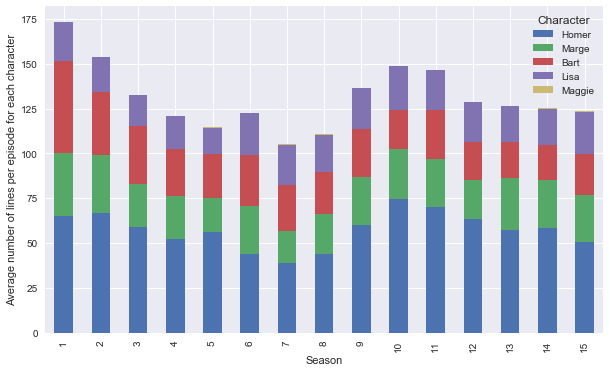

In [13]:
# make season number integer
home_avg_15['season']=home_avg_15['season'].astype(int)
marg_avg_15['season']=marg_avg_15['season'].astype(int)
bart_avg_15['season']=bart_avg_15['season'].astype(int)
lisa_avg_15['season']=lisa_avg_15['season'].astype(int)
magg_avg_15['season']=magg_avg_15['season'].astype(int)

# sort average lines per character by season number
home_avg_15.sort_values(by='season', inplace=True)
marg_avg_15.sort_values(by='season', inplace=True)
bart_avg_15.sort_values(by='season', inplace=True)
lisa_avg_15.sort_values(by='season', inplace=True)
magg_avg_15.sort_values(by='season', inplace=True)

# create dataframe from data
columns=["Character"]
columns.extend(home_avg_15['season'].tolist())
homer=["Homer"]
homer.extend(home_avg_15['avg_lines_per_episode'].tolist())
marge=["Marge"]
marge.extend(marg_avg_15['avg_lines_per_episode'].tolist())
bart=["Bart"]
bart.extend(bart_avg_15['avg_lines_per_episode'].tolist())
lisa=["Lisa"]
lisa.extend(lisa_avg_15['avg_lines_per_episode'].tolist())
maggie=["Maggie"]
maggie.extend(magg_avg_15['avg_lines_per_episode'].tolist())

df2 = pd.DataFrame(columns=columns,
                  data=[homer,
                        marge,
                        bart,
                        lisa,
                        maggie])

# plot stacked bar chart of average number of character lines by season
fig,ax=plt.subplots(figsize=(10,6))
df2.set_index('Character').T.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('Season')
plt.ylabel('Average number of lines per episode for each character')

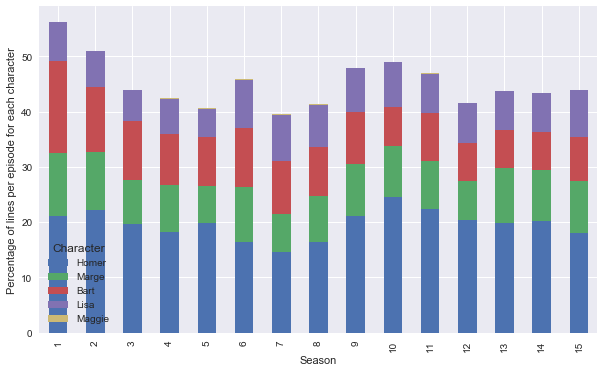

In [14]:
# Normalize above plot

# SQL query to get total number of lines per season

sql_query = """
SELECT season, COUNT(*) AS lines_per_season
FROM episodes ep
LEFT JOIN scripts ON ep.url = scripts.url
WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
GROUP BY season
"""

# Homer

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(lines_per_season AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  AND scripts.text LIKE 'Homer Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS lines_per_season
  FROM episodes ep
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

home_avg_15_norm = pd.read_sql_query(sql_query,con)

# Marge

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(lines_per_season AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  AND scripts.text LIKE 'Marge Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS lines_per_season
  FROM episodes ep
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

marg_avg_15_norm = pd.read_sql_query(sql_query,con)

# Bart

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(lines_per_season AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  AND scripts.text LIKE 'Bart Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS lines_per_season
  FROM episodes ep
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

bart_avg_15_norm = pd.read_sql_query(sql_query,con)

# Lisa

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(lines_per_season AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  AND scripts.text LIKE 'Lisa Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS lines_per_season
  FROM episodes ep
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

lisa_avg_15_norm = pd.read_sql_query(sql_query,con)

# Maggie

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(lines_per_season AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  AND scripts.text LIKE 'Maggie Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS lines_per_season
  FROM episodes ep
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

magg_avg_15_norm = pd.read_sql_query(sql_query,con)

# make season number integer
home_avg_15_norm['season']=home_avg_15_norm['season'].astype(int)
marg_avg_15_norm['season']=marg_avg_15_norm['season'].astype(int)
bart_avg_15_norm['season']=bart_avg_15_norm['season'].astype(int)
lisa_avg_15_norm['season']=lisa_avg_15_norm['season'].astype(int)
magg_avg_15_norm['season']=magg_avg_15_norm['season'].astype(int)

# sort average lines per character by season number
home_avg_15_norm.sort_values(by='season', inplace=True)
marg_avg_15_norm.sort_values(by='season', inplace=True)
bart_avg_15_norm.sort_values(by='season', inplace=True)
lisa_avg_15_norm.sort_values(by='season', inplace=True)
magg_avg_15_norm.sort_values(by='season', inplace=True)

# create dataframe from data
columns=["Character"]
columns.extend(home_avg_15_norm['season'].tolist())
homer=["Homer"]
homer.extend((home_avg_15_norm['avg_lines_per_episode']*100).tolist())
marge=["Marge"]
marge.extend((marg_avg_15_norm['avg_lines_per_episode']*100).tolist())
bart=["Bart"]
bart.extend((bart_avg_15_norm['avg_lines_per_episode']*100).tolist())
lisa=["Lisa"]
lisa.extend((lisa_avg_15_norm['avg_lines_per_episode']*100).tolist())
maggie=["Maggie"]
maggie.extend((magg_avg_15_norm['avg_lines_per_episode']*100).tolist())

df3 = pd.DataFrame(columns=columns,
                  data=[homer,
                        marge,
                        bart,
                        lisa,
                        maggie])

# plot stacked bar chart of average number of character lines by season
fig,ax=plt.subplots(figsize=(10,6))
df3.set_index('Character').T.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('Season')
plt.ylabel('Percentage of lines per episode for each character')

It's interesting to see how the average number of lines per episode for each character by season changes, with the main characters featuring most heavily in season 1 and gradually making way for the many side characters. The plot of percentage of lines per episode for each character by season shows a similar trend, with the main characters responsible for about half the lines in the show and sometimes as low as 40%.

Note that some of the lines in each episode script are not dialogue attributed to a character; they may be setting up a scene or providing other contextual information.

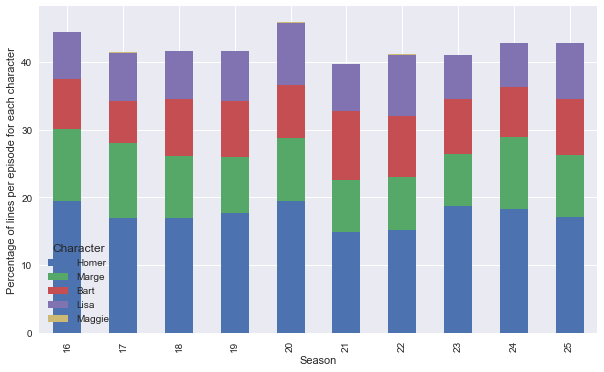

In [15]:
# Percentage of lines per episode for each character for seasons 16-25

# SQL query to get total number of lines per season

sql_query = """
SELECT season, COUNT(*) AS lines_per_season
FROM episodes ep
LEFT JOIN scripts ON ep.url = scripts.url
WHERE season IN ('16','17','18','19','20','21','22','23','24','25')
GROUP BY season
"""

# Homer

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(lines_per_season AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('16','17','18','19','20','21','22','23','24','25')
  AND scripts.text LIKE 'Homer Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS lines_per_season
  FROM episodes ep
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('16','17','18','19','20','21','22','23','24','25')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

home_avg_25_norm = pd.read_sql_query(sql_query,con)

# Marge

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(lines_per_season AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('16','17','18','19','20','21','22','23','24','25')
  AND scripts.text LIKE 'Marge Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS lines_per_season
  FROM episodes ep
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('16','17','18','19','20','21','22','23','24','25')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

marg_avg_25_norm = pd.read_sql_query(sql_query,con)

# Bart

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(lines_per_season AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('16','17','18','19','20','21','22','23','24','25')
  AND scripts.text LIKE 'Bart Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS lines_per_season
  FROM episodes ep
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('16','17','18','19','20','21','22','23','24','25')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

bart_avg_25_norm = pd.read_sql_query(sql_query,con)

# Lisa

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(lines_per_season AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('16','17','18','19','20','21','22','23','24','25')
  AND scripts.text LIKE 'Lisa Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS lines_per_season
  FROM episodes ep
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('16','17','18','19','20','21','22','23','24','25')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

lisa_avg_25_norm = pd.read_sql_query(sql_query,con)

# Maggie

sql_query = """
SELECT sub1.season, CAST(lines AS float)/CAST(lines_per_season AS float) AS avg_lines_per_episode
FROM (
  SELECT season, COUNT(*) AS lines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('16','17','18','19','20','21','22','23','24','25')
  AND scripts.text LIKE 'Maggie Simpson: %'
  GROUP BY season ) sub1
JOIN (
  SELECT season, COUNT(*) AS lines_per_season
  FROM episodes ep
  LEFT JOIN scripts ON ep.url = scripts.url
  WHERE season IN ('16','17','18','19','20','21','22','23','24','25')
  GROUP BY season ) sub2
ON sub1.season=sub2.season
"""

magg_avg_25_norm = pd.read_sql_query(sql_query,con)

# make season number integer
home_avg_25_norm['season']=home_avg_25_norm['season'].astype(int)
marg_avg_25_norm['season']=marg_avg_25_norm['season'].astype(int)
bart_avg_25_norm['season']=bart_avg_25_norm['season'].astype(int)
lisa_avg_25_norm['season']=lisa_avg_25_norm['season'].astype(int)
magg_avg_25_norm['season']=magg_avg_25_norm['season'].astype(int)

# sort average lines per character by season number
home_avg_25_norm.sort_values(by='season', inplace=True)
marg_avg_25_norm.sort_values(by='season', inplace=True)
bart_avg_25_norm.sort_values(by='season', inplace=True)
lisa_avg_25_norm.sort_values(by='season', inplace=True)
magg_avg_25_norm.sort_values(by='season', inplace=True)

# create dataframe from data
columns=["Character"]
columns.extend(home_avg_25_norm['season'].tolist())
homer=["Homer"]
homer.extend((home_avg_25_norm['avg_lines_per_episode']*100).tolist())
marge=["Marge"]
marge.extend((marg_avg_25_norm['avg_lines_per_episode']*100).tolist())
bart=["Bart"]
bart.extend((bart_avg_25_norm['avg_lines_per_episode']*100).tolist())
lisa=["Lisa"]
lisa.extend((lisa_avg_25_norm['avg_lines_per_episode']*100).tolist())
maggie=["Maggie"]
maggie.extend((magg_avg_25_norm['avg_lines_per_episode']*100).tolist())

df4 = pd.DataFrame(columns=columns,
                  data=[homer,
                        marge,
                        bart,
                        lisa,
                        maggie])

# plot stacked bar chart of average number of character lines by season
fig,ax=plt.subplots(figsize=(10,6))
df4.set_index('Character').T.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('Season')
plt.ylabel('Percentage of lines per episode for each character')

The main characters generally hover around 40% of the lines in the later seasons. Some possibilities for further analysis would be seeing how many and which side characters are involved in the later seasons. It's clear that the Simpson family is an integral part of each episode, but there may be limits to the number of scenarios that a nuclear family may find themselves in.

Other way to look for percent of lines by season... working through dataframes

`lines_per_season = pd.read_sql_query(sql_query,con)
lines_per_season['season']=lines_per_season['season'].astype(int)
lines_per_season.sort_values(by='season', inplace=True)`

`# get characters' lines by season without name
dftemp = df2.iloc[:,1:]`

`data1 = {"Homer":dftemp.iloc[0],
         "Marge":dftemp.iloc[1],
         "Bart":dftemp.iloc[2],
         "Lisa":dftemp.iloc[3],
         "Maggie":dftemp.iloc[4]}`

`data2 = {"Homer":[4.],
         "Marge":[2.],
         "Bart":[11.],
         "Lisa":[],
         "Maggie":[]}`

`dfa = pd.DataFrame(data1)
dfb = pd.DataFrame(data2) `

`dfa.div(dfb.iloc[0], axis='columns')`


`rn_df1 = dict(list(zip(df1.columns.values,(df1.columns+'/'+df2.columns))))
rn_df2 = dict(list(zip(df2.columns.values,(df1.columns+'/'+df2.columns))))
df1.rename(columns=rn_df1).div(df2.rename(columns=rn_df2))`

`lines_per_season['lines_per_season']`

`dflines = pd.DataFrame(data1)
dflines.merge(lines_per_season, on="season")`

`dflines['Bart'].div(lines_per_season['lines_per_season'])`

`data1 = {"Homer":dftemp.iloc[0],
         "Marge":dftemp.iloc[1],
         "Bart":dftemp.iloc[2],
         "Lisa":dftemp.iloc[3],
         "Maggie":dftemp.iloc[4]}`

`pd.DataFrame(data1)`

`dftemp = df2.iloc[:,1:]
[dftemp.iloc[0]]`

`df2.iloc[1]
lines_per_season`

In [16]:
# verification of lines per episode by character
sql_query = """
SELECT ep.season, ep.number, ep.name, scripts.text FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE season='7'
  AND scripts.text LIKE 'Homer Simpson: %'
"""
sql_out = pd.read_sql_query(sql_query,con)
#sql_out.shape

sql_query = """
  SELECT season, COUNT(*) AS homelines FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE season IN ('1','2','3','4','5','6','7','8','9','10')
  AND scripts.text LIKE 'Homer Simpson: %'
  GROUP BY season
"""
sql_out = pd.read_sql_query(sql_query,con)
#sql_out

## D3.js visualization